# Exploratory data analysis on the San Francisco 311 data
Data can be downloaded from: https://data.sfgov.org/City-Infrastructure/311-Cases/vw6y-z8j6/data

In [2]:
%matplotlib inline
%load_ext autoreload
import matplotlib.pyplot as plt

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np

## The time window to bucket samples
TIME_RANGE = '24H'

## File path (original data is ~1GB, this is a reduced version with only categories and dates)
#Original file:
#DATAPATH = "SF311_simplified.csv"

#Sample raw data:
DATAPATH = "SF_data/SF-311_simplified.csv"

### Read sample of data (original data contains additional columns)

In [23]:
raw_sample = pd.read_csv(DATAPATH, nrows=5)
raw_sample.head()

,Unnamed: 0,Opened,Category,Request Details
0,0,07/02/2008 03:16:55 PM,Tree Maintenance,Lifted_sidewalk_tree_roots
1,1,07/02/2008 04:47:08 PM,Tree Maintenance,Hanging_limb
2,2,07/02/2008 05:54:07 PM,Tree Maintenance,Blocking_street_lights
3,3,07/03/2008 12:38:04 PM,Tree Maintenance,Sprinkler_system_issues
4,4,07/03/2008 12:44:26 PM,Street and Sidewalk Cleaning,Other Loose Garbage


In [24]:
raw = pd.read_csv(DATAPATH).drop(columns='Unnamed: 0')
raw.head(10)

,Opened,Category,Request Details
0,07/02/2008 03:16:55 PM,Tree Maintenance,Lifted_sidewalk_tree_roots
1,07/02/2008 04:47:08 PM,Tree Maintenance,Hanging_limb
2,07/02/2008 05:54:07 PM,Tree Maintenance,Blocking_street_lights
3,07/03/2008 12:38:04 PM,Tree Maintenance,Sprinkler_system_issues
4,07/03/2008 12:44:26 PM,Street and Sidewalk Cleaning,Other Loose Garbage
5,07/03/2008 01:24:07 PM,Tree Maintenance,Lifted_sidewalk_tree_roots
6,07/07/2008 03:14:07 PM,Tree Maintenance,Near_communication_line
7,07/08/2008 06:25:18 PM,Tree Maintenance,About_to_fall
8,07/09/2008 02:57:52 PM,Tree Maintenance,Near_communication_line
9,07/09/2008 04:57:24 PM,Tree Maintenance,Near_communication_line


#### Initial data prep

In [25]:
## Rename columns
raw = raw.rename(columns={'Opened': 'date', 'Category': 'category'})
print(raw.head())
## Turn the raw data into a time series (with date as DatetimeIndex)
from moda.dataprep import raw_to_ts
ts = raw_to_ts(raw,date_format="%m/%d/%Y %H:%M:%S %p")

                     date                      category  \
0  07/02/2008 03:16:55 PM              Tree Maintenance   
1  07/02/2008 04:47:08 PM              Tree Maintenance   
2  07/02/2008 05:54:07 PM              Tree Maintenance   
3  07/03/2008 12:38:04 PM              Tree Maintenance   
4  07/03/2008 12:44:26 PM  Street and Sidewalk Cleaning   

              Request Details  
0  Lifted_sidewalk_tree_roots  
1                Hanging_limb  
2      Blocking_street_lights  
3     Sprinkler_system_issues  
4         Other Loose Garbage  


In [26]:
ts.head()

,category,Request Details,timestamp
date,,,
2008-07-02 03:16:55,Tree Maintenance,Lifted_sidewalk_tree_roots,1214968615
2008-07-02 04:47:08,Tree Maintenance,Hanging_limb,1214974028
2008-07-02 05:54:07,Tree Maintenance,Blocking_street_lights,1214978047
2008-07-03 12:38:04,Tree Maintenance,Sprinkler_system_issues,1215088684
2008-07-03 12:44:26,Street and Sidewalk Cleaning,Other Loose Garbage,1215089066


In [27]:
## Some general stats

print("Dataset length: " + str(len(ts)))
print("Min date: " + str(ts.index.get_level_values('date').min()))
print("Max date: " + str(ts.index.get_level_values('date').max()))

print("Total time: {}".format(ts.index.get_level_values('date').max() - ts.index.get_level_values('date').min()))

print("Dataset contains {} categories.".format(len(ts['category'].unique())))



Dataset length: 3133199
Min date: 2008-07-01 01:00:00
Max date: 2018-08-25 12:36:54
Total time: 3707 days 11:36:54
Dataset contains 102 categories.


#### Next, we decide on the time interval and aggregate items per time and category

In [28]:
from moda.dataprep import ts_to_range
ranged_ts = ts_to_range(ts,time_range=TIME_RANGE)
ranged_ts.head(20)

value
date       category                           
2008-07-01 311 External Request           19.0
           Abandoned Vehicle              44.0
           Blocked Street or SideWalk      3.0
           Construction Zone Permits      20.0
           DPW Volunteer Programs          1.0
           Damaged Property               11.0
           Encampments                    20.0
           Graffiti                       51.0
           Homeless Concerns              18.0
           Litter Receptacles             12.0
           SFHA Requests                  48.0
           Sewer Issues                   10.0
           Sidewalk or Curb                6.0
           Sign Repair                    30.0
           Street Defects                 14.0
           Street and Sidewalk Cleaning  194.0
           Tree Maintenance               21.0
2008-07-02 311 External Request           20.0
           Abandoned Vehicle              38.0
           Blocked Street or SideWalk      2.0

In [8]:
#I'm using dfply because I like its functional-like syntax. This can also be done with plain pandas.
#!pip install dfply
from dfply import *

## Remove categories with less than 1000 items (in more than 10 years) or that existed less than 100 days
min_values = 1000
min_days = 100



categories = ranged_ts.reset_index() >> group_by(X.category) >> \
    summarise(value = np.sum(X.value),duration_in_dataset = X.date.max()-X.date.min()) >> \
    ungroup() >> \
    mask(X.duration_in_dataset.dt.days > min_days) >> \
    mask(X.value > min_values) >> \
    arrange(X.value,ascending=False)



print("Filtered dataset contains {0} categories,\nafter filtering the small ones that existed less than {1} days or had {2} values of less.".
      format(len(categories),min_days,min_values))

categories.head()

Filtered dataset contains 46 categories,
after filtering the small ones that existed less than 100 days or had 1000 values of less.


,category,value,duration_in_dataset
98,Street and Sidewalk Cleaning,869024.0,3705 days
83,Graffiti,457827.0,3706 days
88,MUNI Feedback,198420.0,3373 days
1,Abandoned Vehicle,194940.0,3706 days
84,Homeless Concerns,160384.0,3700 days


### Most common categories

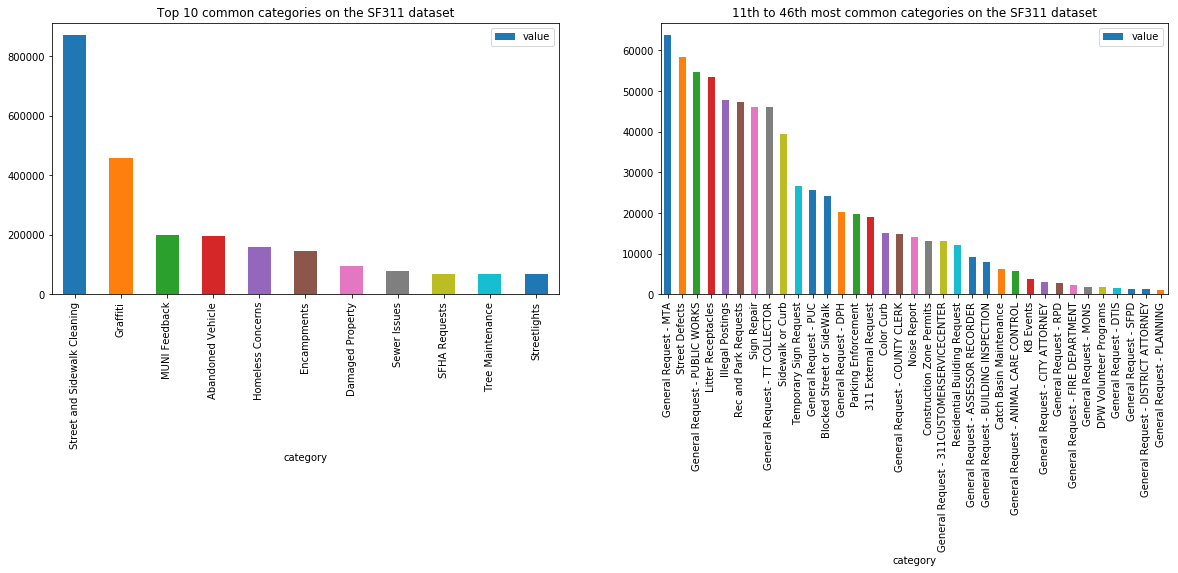

In [9]:
category_names = categories['category'].values
num_categories = len(categories)

major_category_threshold=11
major_categories = category_names[:major_category_threshold]
minor_categories = category_names[major_category_threshold:]

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(5)
fig.set_figwidth(20)

categories[categories['category'].isin(major_categories)].plot(kind='bar',
                                                               x='category',
                                                               y='value',
                                                               title="Top "+str(major_category_threshold-1)+" common categories on the SF311 dataset",
                                                               ax=axes[0])
categories[categories['category'].isin(minor_categories)].plot(kind='bar',
                                                               x='category',
                                                               y='value',
                                                               title=str(major_category_threshold)+"th to "+str(num_categories)+"th most common categories on the SF311 dataset",
                                                               ax=axes[1])

plt.savefig("category_values.png",bbox_inches='tight')

### Change in requests per category from year to year

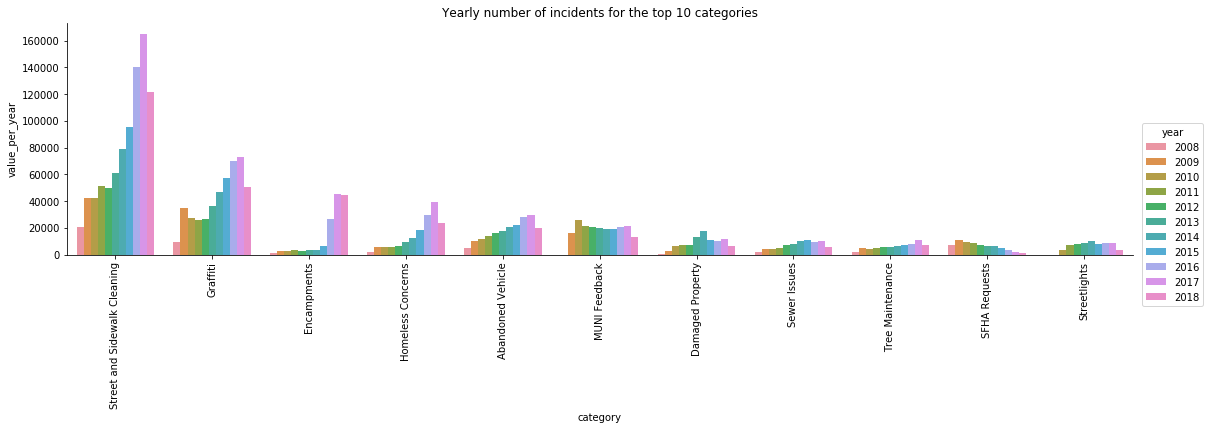

In [10]:
## Calculate the number of values per category per year
categories_yearly = ranged_ts.reset_index() >> mutate(year = X.date.dt.year) >> group_by(X.category,X.year) >> \
    summarise(value_per_year = np.sum(X.value),
              duration_in_dataset = X.date.max()-X.date.min()) >>\
    ungroup() >> \
    mask(X.value_per_year > (min_values/12.0)) >> \
    arrange(X.value_per_year,ascending=False)

import seaborn as sns

major_cats_yearly = categories_yearly[categories_yearly['category'].isin(major_categories)]

g = sns.factorplot(x='category', y='value_per_year', hue='year', data=major_cats_yearly, kind='bar', size=4, aspect=4,legend=True)
g.set_xticklabels(rotation=90)
axes = g.axes.flatten()
axes[0].set_title("Yearly number of incidents for the top "+str(major_category_threshold-1)+" categories")
plt.savefig("yearly_values.png",bbox_inches='tight')

Text(0.5,1,'Yearly number of incidents for the 11th to 46th categories')

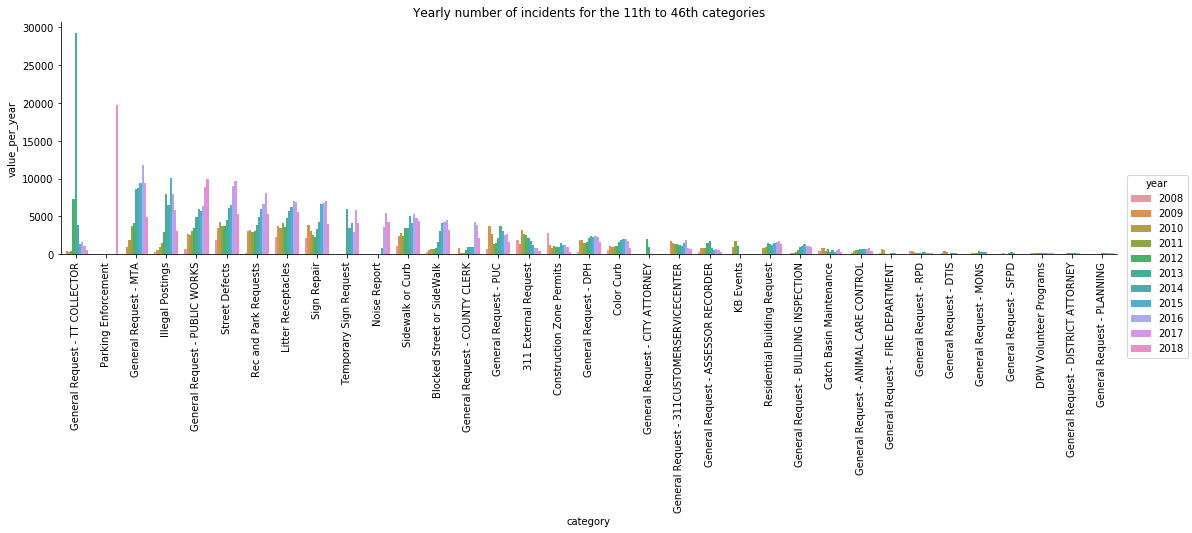

In [11]:
minor_cats_yearly = categories_yearly[categories_yearly['category'].isin(minor_categories)]

g = sns.factorplot(x='category', y='value_per_year', hue='year', data=minor_cats_yearly, kind='bar', size=4, aspect=4,legend=True)
g.set_xticklabels(rotation=90)
axes = g.axes.flatten()
axes[0].set_title("Yearly number of incidents for the "+str(major_category_threshold)+"th to "+str(num_categories)+"th categories")

### Correlation between categories over time

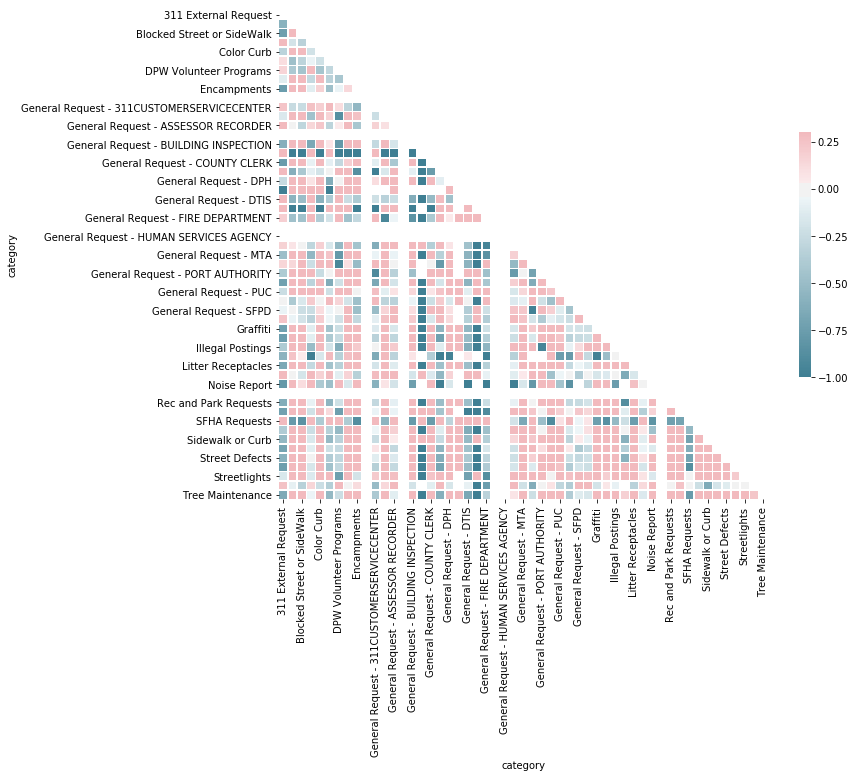

In [12]:
categories_yearly_pivot = categories_yearly.pivot("year", "category", "value_per_year")
categories_yearly_pivot.head()
corr = categories_yearly_pivot.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### One category inspection
#### Example 1: Noise Reports

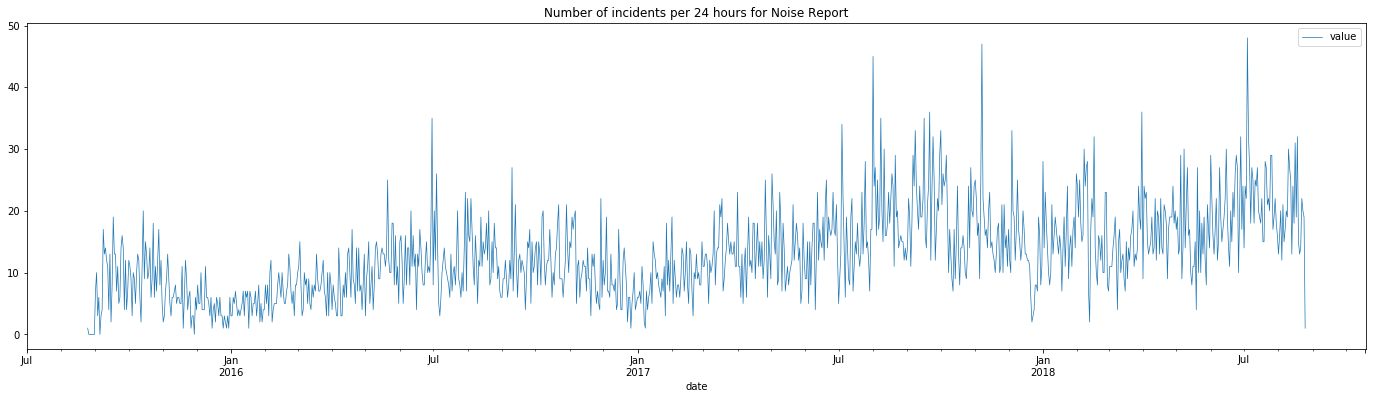

In [13]:
category = "Noise Report"
ranged_ts.loc[pd.IndexSlice[:, category], :].reset_index().plot(kind='line',x='date',y='value',figsize=(24,6),linewidth=0.7, 
                          title = "Number of incidents per 24 hours for {}".format(category))

#### Example 2: Street and Sidewalk Cleaning

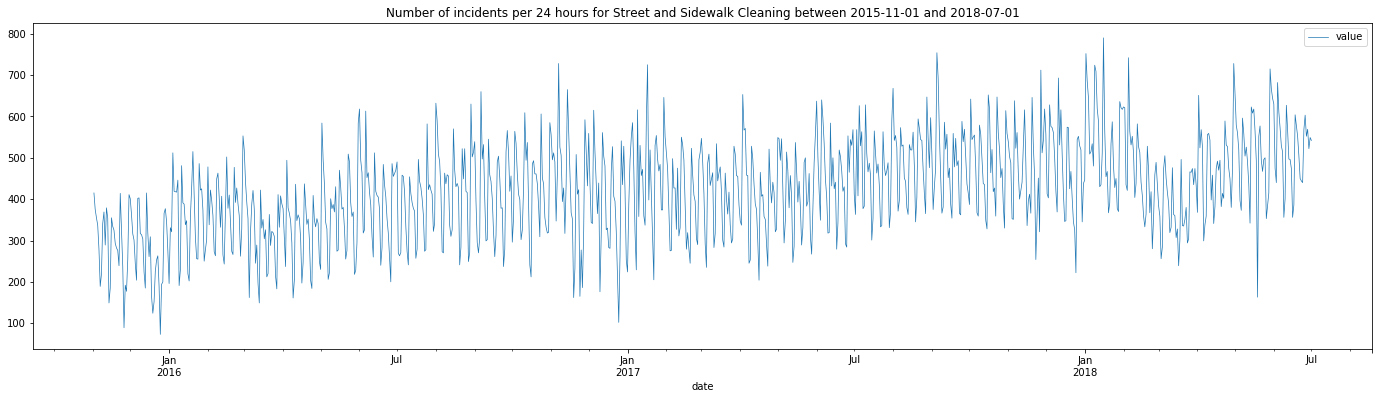

In [14]:
START = '2015-11-01'
END = '2018-07-01'
category = 'Street and Sidewalk Cleaning'
cleaning = ranged_ts.loc[pd.IndexSlice[:, category], :].reset_index()
cleaning[(cleaning.date > START) & (cleaning.date<=END)].plot(kind='line',x='date',y='value',figsize=(24,6),linewidth=0.7, 
                          title = "Number of incidents per 24 hours for {0} between {1} and {2}".format(category,START,END))

As comparison, let's look at the same time series with different time ranges (30 minutes, 1 hour and 24 hours), only on two months of data

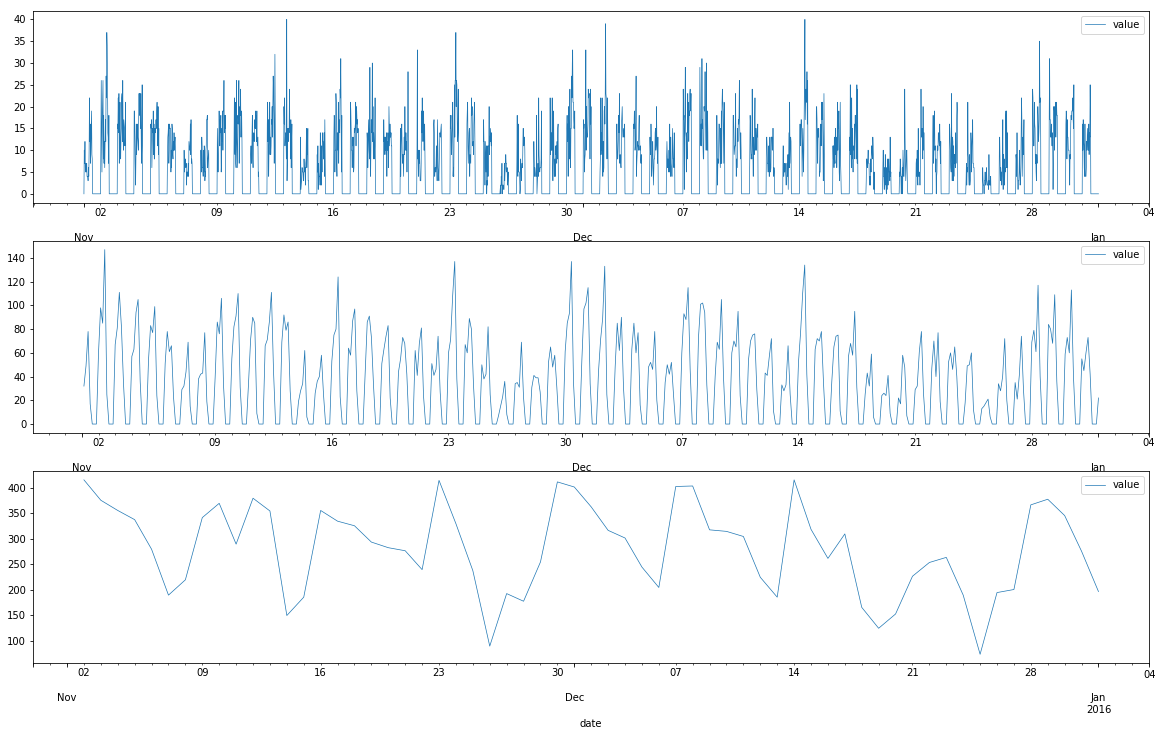

In [15]:
from moda.dataprep.ts_to_range import ts_to_range
ranged_ts_3H = ts_to_range(ts,time_range='3H',pad_with_zeros=True)
ranged_ts_30min = ts_to_range(ts,time_range='30min',pad_with_zeros=True)

START = '2015-11-01'
END = '2016-01-01'
category = 'Street and Sidewalk Cleaning'

fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(20,12))

cleaning_30min = ranged_ts_30min.loc[pd.IndexSlice[:, category], :].reset_index()
a1=cleaning_30min[(cleaning_30min.date > START) & (cleaning_30min.date<=END)].plot(kind='line',x='date',y='value',linewidth=0.7, ax=axes[0])

cleaning_3H = ranged_ts_3H.loc[pd.IndexSlice[:, category], :].reset_index()
a2=cleaning_3H[(cleaning_3H.date > START) & (cleaning_3H.date<=END)].plot(kind='line',x='date',y='value',linewidth=0.7, ax=axes[1])

cleaning_24H = ranged_ts.loc[pd.IndexSlice[:, category], :].reset_index()
a3=cleaning_24H[(cleaning_24H.date > START) & (cleaning_24H.date<=END)].plot(kind='line',x='date',y='value',linewidth=0.7, ax=axes[2])


We can see that there are multiple seasonality factors in this time series. Hourly and weekly patterns are visible on the 30 minute interval time series, and the 3 hours interval time series

## Evaluating different models on the SF 24H data

First, in order to be able to estimate our models, we use [TagAnomaly](https://github.com/Microsoft/TagAnomaly) to tag the points we think are showing trends in the data. Taganomaly can be found here: https://github.com/Microsoft/TagAnomaly
Second, we join the tagged dataset with the time series dataset. Each sample which isn't included in the tagged dataset is assumed to be non-trending (or normal)

In [16]:
## Add labeled data
labels24H = pd.read_csv('SF_data/SF_24H_anomalies_only.csv',usecols=['date','category','value'])
labels24H.date = pd.to_datetime(labels24H.date)

labels24H['label'] = 1
labels24H.sort_values(by='date').head()

,date,category,value,label
52,2018-01-07,Sidewalk or Curb,34,1
41,2018-01-08,Sewer Issues,168,1
8,2018-01-08,Catch Basin Maintenance,19,1
24,2018-01-08,General Request - PUC,38,1
73,2018-01-09,Temporary Sign Request,62,1


In [17]:
# Since we have labels only for 2018, we'll filter out previous years.
ts2018 = ranged_ts[ranged_ts.index.get_level_values(0).year == 2018]
ts2018.head()

value
date       category                         
2018-01-01 311 External Request          0.0
           Abandoned Vehicle            52.0
           Blocked Street or SideWalk   14.0
           Catch Basin Maintenance       1.0
           Color Curb                    2.0

In [18]:
df24H = pd.merge(ts2018.reset_index(),labels24H,how='left',on=['date','category'])
df24H['label'] = np.where(np.isnan(df24H['value_y']),0,1)
df24H = df24H.set_index([pd.DatetimeIndex(df24H['date']),'category'])
df24H = df24H.drop(columns = ['date','value_y']).rename(columns = {'value_x':'value'})
df24H.head()
df24H.to_csv("SF24H_labeled.csv")

In [19]:
len(df24H)

18059

In [20]:
from moda.evaluators import get_metrics_for_all_categories, get_final_metrics
from moda.dataprep import read_data
from moda.models import TwitterAnomalyTrendinessDetector, MovingAverageSeasonalTrendinessDetector, \
    STLTrendinessDetector, AzureAnomalyTrendinessDetector


def run_model(dataset, freq, min_date='01-01-2018', plot=False, model_name='stl', min_value=10,
              min_samples_for_category=100):


    if model_name == 'twitter':
        model = TwitterAnomalyTrendinessDetector(is_multicategory=True, freq=freq, min_value=min_value, threshold=None,
                                                 max_anoms=0.49, seasonality_freq=7)

    if model_name == 'ma_seasonal':
        model = MovingAverageSeasonalTrendinessDetector(is_multicategory=True, freq=freq, min_value=min_value,
                                                        anomaly_type='or',
                                                        num_of_std=3)

    if model_name == 'stl':
        model = STLTrendinessDetector(is_multicategory=True, freq=freq, min_value=min_value,
                                      anomaly_type='residual',
                                      num_of_std=3, lo_delta=0)

    if model_name == 'azure':
        dirname = os.path.dirname(__file__)
        filename = os.path.join(dirname, 'config/config.json')
        subscription_key = get_azure_subscription_key(filename)
        model = AzureAnomalyTrendinessDetector(is_multicategory=True, freq=freq, min_value=min_value,
                                               subscription_key=subscription_key)
    
    # There is no fit/predict here. We take the entire time series and can evaluate anomalies on all of it or just the last window(s)
    prediction = model.predict(dataset, verbose=False)
    raw_metrics = get_metrics_for_all_categories(dataset[['value']], prediction[['prediction']], dataset[['label']],
                                                 window_size_for_metrics=5)
    metrics = get_final_metrics(raw_metrics)
    print(metrics)

    ## Plot each category
    if plot:
        print("Plotting...")
        model.plot(labels=dataset['label'],savefig=False)

    return prediction


ModuleNotFoundError: No module named 'moda.models.azure_anomaly_detection'

In [ ]:
prediction_stl = run_model(df24H,freq='24H',model_name='stl')

In [ ]:
def plot_one_category(category_dataset,model_name='stl'):

    def ts_subplot(plt, series, label):
        plt.plot(series, label=label, linewidth=0.5)
        plt.legend(loc='best')
        plt.xticks(rotation=90)

    plt.subplot(421, )
    ts_subplot(plt, category_dataset['value'], label='Original')
    if 'residual_anomaly' in category_dataset:
        plt.subplot(422)
        ts_subplot(plt, category_dataset['residual_anomaly'], label='Residual anomaly')
    if 'trend' in category_dataset:
        plt.subplot(423)
        ts_subplot(plt, category_dataset['trend'], label='Trend')
    if 'trend_anomaly' in category_dataset:
        plt.subplot(424)
        ts_subplot(plt, category_dataset['trend_anomaly'], label='Trend anomaly')
    if 'seasonality' in category_dataset:
        plt.subplot(425)
        ts_subplot(plt, category_dataset['seasonality'], label='Seasonality')
    
    plt.subplot(426)
    ts_subplot(plt, category_dataset['prediction'], label='Prediction')
    
    if 'residual' in category_dataset:
        plt.subplot(427)
        ts_subplot(plt, category_dataset['residual'], label='Residual')

    plt.subplot(428)
    ts_subplot(plt, category_dataset['label'], label='Labels')
    
    category = category_dataset.category[0]
    
    plt.suptitle("{} results for category {}".format(model_name, category))



In [ ]:
graffiti = prediction_stl.loc[pd.IndexSlice[:, 'Graffiti'], :].reset_index(level='category', drop=False)
fig = plt.figure(figsize=(20,8))
plot_one_category(graffiti,model_name='STL')

The time series in this case is relatively noisy. The model was more conservative than the labeler in this case.

In [ ]:
sewer = prediction_stl.loc[pd.IndexSlice[:, 'Sewer Issues'], :].reset_index(level='category', drop=False)
fig = plt.figure(figsize=(20,8))
plot_one_category(sewer,model_name='STL')

In this case, we missed the first peak as we didn't have enough historical data to estimate it. Let's compare this result to a different model:

In [ ]:
prediction_ma = run_model(df24H,freq=TIME_RANGE,model_name='ma_seasonal')

In [ ]:
sewer2 = prediction_ma.loc[pd.IndexSlice[:, 'Sewer Issues'], :].reset_index(level='category', drop=False)
fig = plt.figure(figsize=(20,8))
plot_one_category(sewer2,model_name='MA seasonal')

This model estimates the trend differently, and found some anomalies on the trend series as well. It too couldn't detect the first peak as it requires some historical data to estimate standard deviation and other statistics.